 - Barry Saliou
 - Zhang Zhile

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [89]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

In [90]:
def thresholdImage(I,s):
    """ Array*int -> Array """
    I2 = I.copy()
    I2[I2 < s] = 0
    I2[I2 != 0] = 255
    return I2

## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [91]:
lena = np.array(Image.open('img/lena.png'))

Sx = np.array([[1 , 0,  -1], [2, 0, -2], [1, 0, -1] ])
Sy = np.array([[1 , 2,  1], [0, 0, 0], [-1, -2, -1] ])

In [92]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Ix = convolve2d(I, Sx, mode='same')
    Iy = convolve2d(I, Sy, mode= 'same')
    Ig = np.sqrt(Ix**2 + Iy**2)
    Ig = thresholdImage(Ig, s)

    return Ig, Ix, Iy

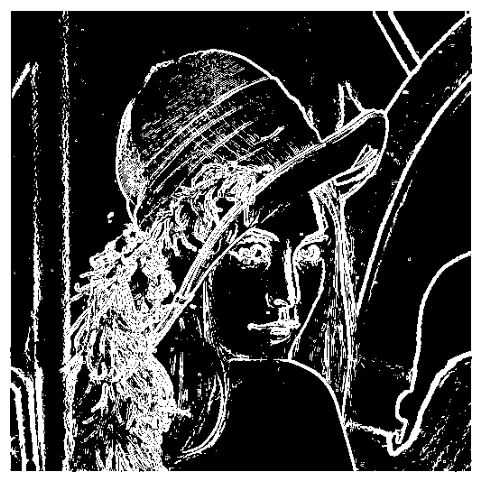

In [93]:
Ig, _, _ = SobelDetector(lena, 70)
imshow(Ig)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [94]:
# Define the Laplacian filter
L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

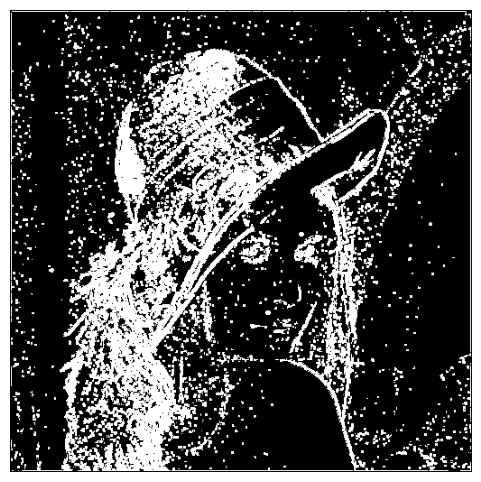

In [95]:
def LaplacianDetector(I, s):
    """ Detect zero crossings in the Laplacian of the image using a Laplacian filter and threshold s """
    
    # Convolve the image with the Laplacian filter
    I_l = convolve2d(I, L, mode='same')

    # Initialize an output image to mark zero crossings
    zero_crossings = np.zeros(I_l.shape)

    # Iterate over the image and find zero crossings
    for i in range(1, I_l.shape[0] - 1):
        for j in range(1, I_l.shape[1] - 1):

            # Extract the 3x3 neighborhood
            neighborhood  = I_l[i-1:i+2, j-1:j+2]

            # Find the minimum and maximum values in the neighborhood
            min_val = np.min(neighborhood)
            max_val = np.max(neighborhood)

            # Check for zero crossing conditions
            if max_val > 0 and min_val < 0 and max_val - min_val > s:
                zero_crossings[i, j] = 255

    return zero_crossings
            

imshow(LaplacianDetector(lena, 70))

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

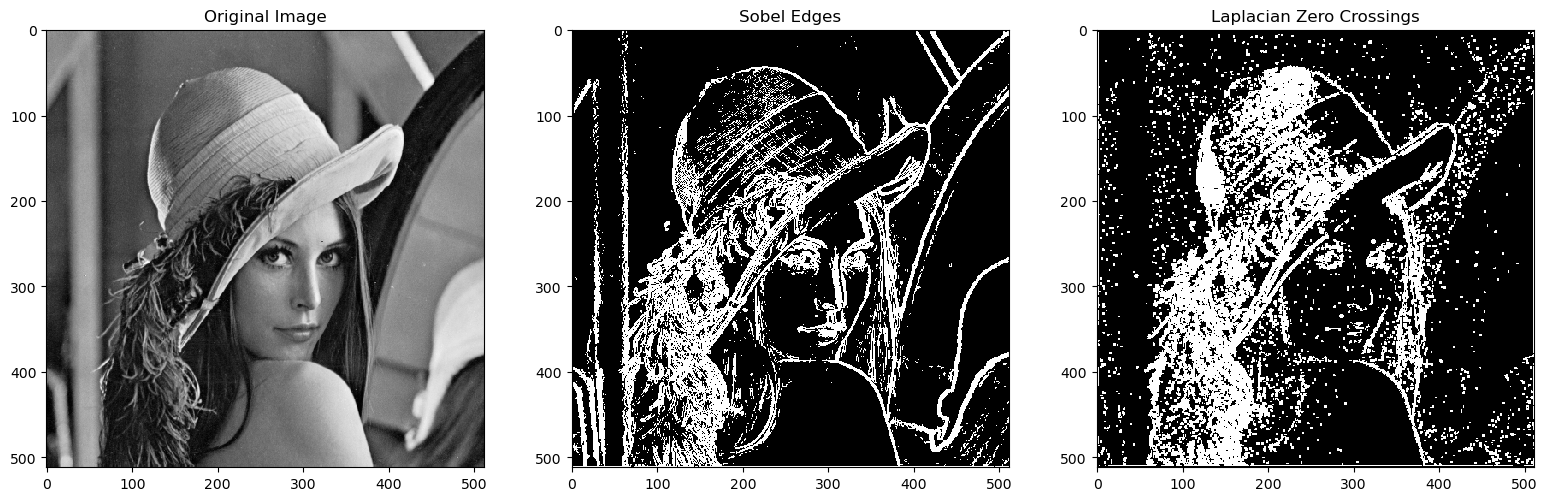

In [96]:
# Apply the Sobel detector
sobel_threshold = 70
sobel_result, _, _ = SobelDetector(lena, sobel_threshold)

# Apply the Laplacian detector
laplacian_threshold = 70
laplacian_result = LaplacianDetector(lena, laplacian_threshold)

# Display the results
niceDisplay14([lena, sobel_result, laplacian_result], ["Original Image", "Sobel Edges", "Laplacian Zero Crossings"])


```We can find that the Laplacian Detector has more noise compare to the Sobel Detector. In the detection of image edges, Sobel Detector works better than Laplacian Detector, and we found that there are some features whose edges are not well detected when Laplacian is applied, such as the edges of the nose. But in the comparison of detection of higher frequency details, Laplacian Detector is better, as we can see that Sobel Detector detects the wall behind the woman along with some unimportant features(low frequency details), but Laplacian Detector focuses on detecting the high frequency details, such as the portrait in the image.```

## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

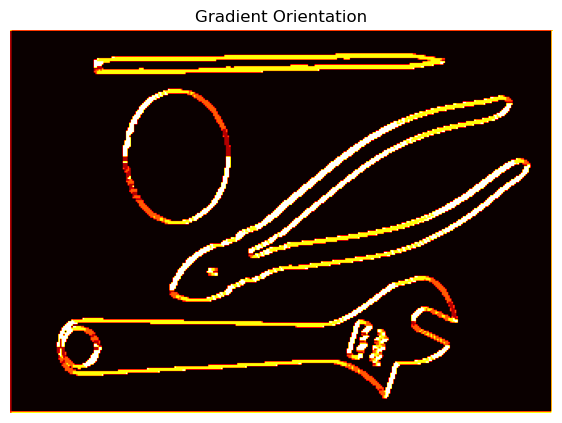

In [99]:
# %matplotlib notebook
## your answer below

# Load the 'tools.png' image
tools = np.array(Image.open('img/tools.png'))

# Apply the Sobel detector
Ig, Ix, Iy = SobelDetector(tools, 70)

# Compute the orientation of the gradient using the orientation function
gradient_orientation = orientation(Ix, Iy, Ig)

# Display the gradient orientation using imshow_hot
imshow_hot(gradient_orientation, title="Gradient Orientation", size=600)


Explain the different values given to a pixel by `orientation()`:

<tt>
The orientation() function assigns values to each pixel in the image based on the local orientation of the gradient. The assigned values represent different orientations, and they are as follows:
<br>
Value 1: Corresponds to an orientation of 0 radians or 0 degrees, which indicates that the gradient is horizontal, moving from left to right.
<br>
Value 2: Corresponds to an orientation of π/4 radians or 45 degrees, indicating that the gradient is diagonal, moving from the bottom-left to the top-right.
<br>
Value 3: Corresponds to an orientation of π/2 radians or 90 degrees, indicating that the gradient is vertical, moving from top to bottom.
<br>
Value 4: Corresponds to an orientation of 3π/4 radians or 135 degrees, indicating that the gradient is diagonal, moving from the bottom-right to the top-left.
</tt>

```By imshow_hot(), we can clearly see the value of each pixel, value 1 is red, value 2 is orange, value 3 is yellow and value 4 is white```

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [111]:
def nms(Ig, Ior):
    """
    Perform non-maximum suppression on the gradient norm based on the gradient orientation.

    Parameters:
    Ig (numpy.ndarray): The gradient norm image.
    Ior (numpy.ndarray): The image of gradient orientations.

    Returns:
    G (numpy.ndarray): An image with gradient norms where pixels are local maxima in the direction of the gradient.
    """

    # Get the shape of the image
    rows, cols = Ig.shape

    # Create an output image initialized with zeros
    G = np.zeros((rows, cols))

    # Iterate over the image to perform non-maximum suppression
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Get the gradient orientation value at the current pixel
            orientation = Ior[i, j]

            # Determine the neighboring pixels along the gradient direction
            if orientation == 1:  # Horizontal (left to right)
                neighbors = [Ig[i, j - 1], Ig[i, j], Ig[i, j + 1]]
            elif orientation == 2:  # Diagonal (bottom-left to top-right)
                neighbors = [Ig[i + 1, j - 1], Ig[i, j], Ig[i - 1, j + 1]]
            elif orientation == 3:  # Vertical (top to bottom)
                neighbors = [Ig[i + 1, j], Ig[i, j], Ig[i - 1, j]]
            elif orientation == 4:  # Diagonal (bottom-right to top-left)
                neighbors = [Ig[i + 1, j + 1], Ig[i, j], Ig[i - 1, j - 1]]

            # Check if the current pixel has the maximum gradient norm among its neighbors
            if Ig[i, j] == max(neighbors):
                G[i, j] = Ig[i, j]

    return G


In [ ]:
"""
def nms(Ig, Ior):
    n, m = Ig.shape
    I_nms = Ig.copy()
    for i in range(1, n - 1):
        for j in range(1, m - 1):
            if Ior[i, j] == 1:
                if Ig[i, j] < Ig[i, j - 1] or Ig[i, j] < Ig[i, j + 1]:
                    I_nms[i, j] = 0
            elif Ior[i, j] == 2:
                if Ig[i, j] < Ig[i - 1, j + 1] or Ig[i, j] < Ig[i + 1, j - 1]:
                    I_nms[i, j] = 0
            elif Ior[i, j] == 3:
                if Ig[i, j] < Ig[i - 1, j] or Ig[i, j] < Ig[i + 1, j]:
                    I_nms[i, j] = 0
            elif Ior[i, j] == 4:
                if Ig[i, j] < Ig[i - 1, j - 1] or Ig[i, j] < Ig[i + 1, j + 1]:
                    I_nms[i, j] = 0
    return I_nms
"""

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


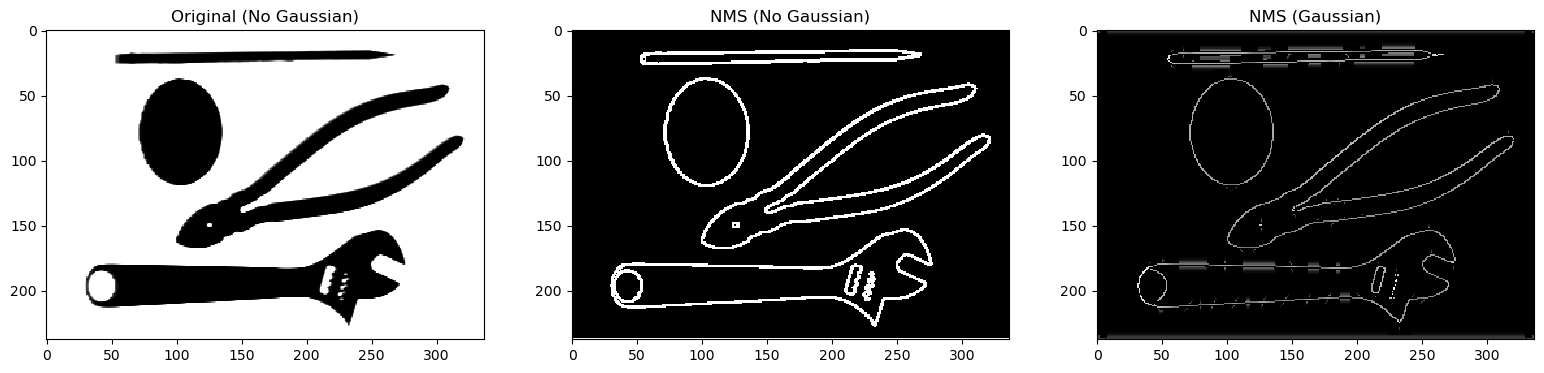

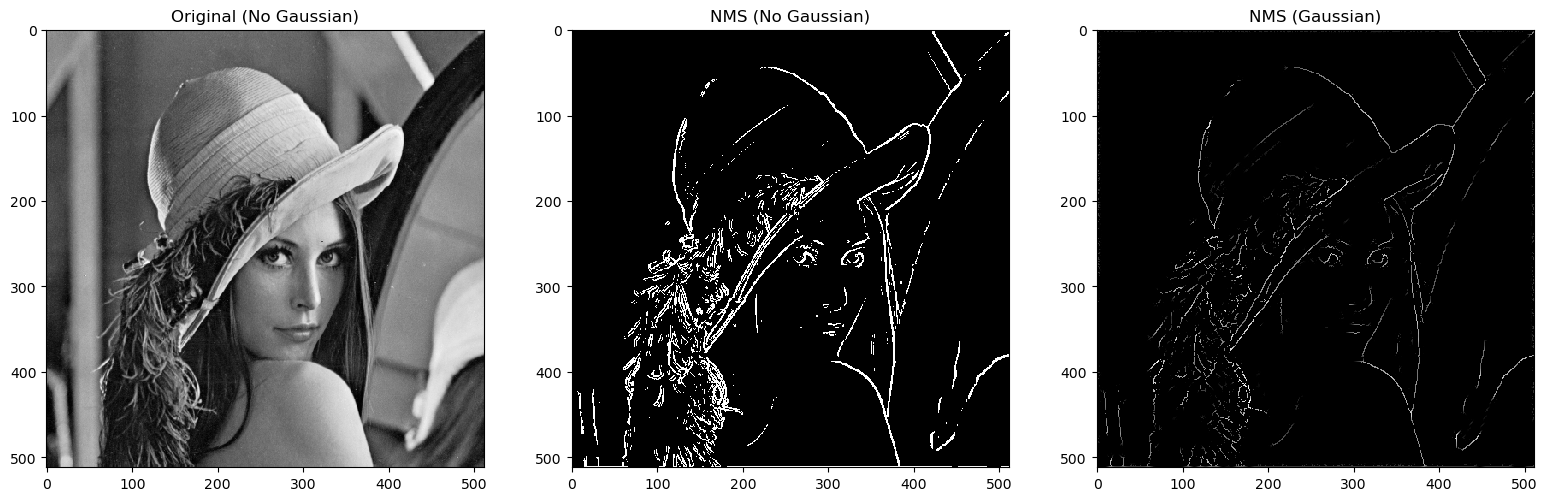

In [102]:
# Load the 'tools.png' and 'lena.png' images
tools = np.array(Image.open('img/tools.png'))
lena = np.array(Image.open('img/lena.png'))


# Apply the Sobel detector with a threshold of 70
tools_Ig, tools_Ix, tools_Iy = SobelDetector(tools, sobel_threshold)
lena_Ig, lena_Ix, lena_Iy = SobelDetector(lena, sobel_threshold)

# Create Gaussian kernels
sigma = 2.0
gaussian_kernel = gaussianKernel(sigma)

# Apply the Gaussian filter
tools_Ig_smoothed = convolve2d(tools_Ig, gaussian_kernel, mode='same')
lena_Ig_smoothed = convolve2d(lena_Ig, gaussian_kernel, mode='same')

# Compute gradient orientations
tools_orientation = orientation(tools_Ix, tools_Iy, tools_Ig_smoothed)
lena_orientation = orientation(lena_Ix, lena_Iy, lena_Ig_smoothed)

# Apply non-maximum suppression with Gaussian smoothing
tools_nms_smoothed = nms(tools_Ig_smoothed, tools_orientation)
lena_nms_smoothed = nms(lena_Ig_smoothed, lena_orientation)

# Apply non-maximum suppression without Gaussian smoothing
tools_nms = nms(tools_Ig, tools_orientation)
lena_nms = nms(lena_Ig, lena_orientation)

# Display the results
niceDisplay14([tools, tools_nms, tools_nms_smoothed], ["Original (No Gaussian)", "NMS (No Gaussian)", "NMS (Gaussian)"])
niceDisplay14([lena, lena_nms, lena_nms_smoothed], ["Original (No Gaussian)", "NMS (No Gaussian)", "NMS (Gaussian)"])



4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

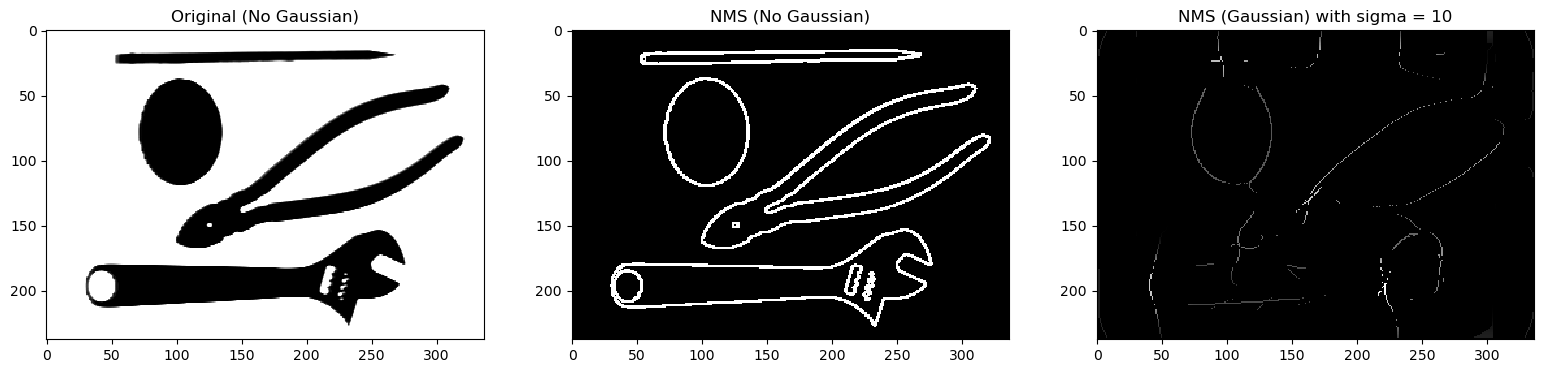

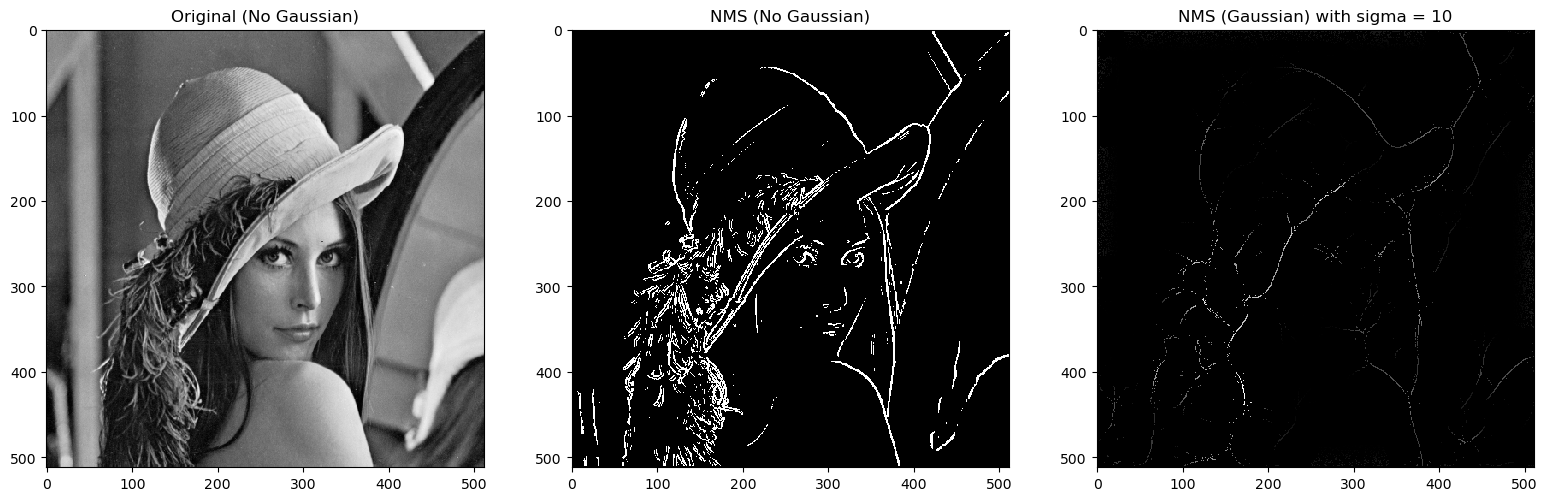

In [114]:
# Create Gaussian kernels
# Higher 𝜎
sigma = 10.0
gaussian_kernel = gaussianKernel(sigma)

# Apply the Gaussian filter
tools_Ig_smoothed = convolve2d(tools_Ig, gaussian_kernel, mode='same')
lena_Ig_smoothed = convolve2d(lena_Ig, gaussian_kernel, mode='same')

# Compute gradient orientations
tools_orientation = orientation(tools_Ix, tools_Iy, tools_Ig_smoothed)
lena_orientation = orientation(lena_Ix, lena_Iy, lena_Ig_smoothed)

# Apply non-maximum suppression with Gaussian smoothing
tools_nms_smoothed = nms(tools_Ig_smoothed, tools_orientation)
lena_nms_smoothed = nms(lena_Ig_smoothed, lena_orientation)

# Apply non-maximum suppression without Gaussian smoothing
tools_nms = nms(tools_Ig, tools_orientation)
lena_nms = nms(lena_Ig, lena_orientation)

# Display the results
niceDisplay14([tools, tools_nms, tools_nms_smoothed], ["Original (No Gaussian)", "NMS (No Gaussian)", "NMS (Gaussian) with sigma = 10"])
niceDisplay14([lena, lena_nms, lena_nms_smoothed], ["Original (No Gaussian)", "NMS (No Gaussian)", "NMS (Gaussian) with sigma = 10"])


 - Smoothing on the edge detection process：
     - Higher $\sigma$: This can lead to loss of edge information because it results in a smoother image, where details and noise are suppressed, so that edges in the image become less visible and the magnitude of the gradient at the edges is reduced. (We can see clearly with $\sigma$ = 2 et $\sigma$ = 10)
     - Lower $\sigma$: In contrast to higher $\sigma$, lower $\sigma$ results in sharper edges and higher edge gradient magnitudes, preserving some noise and details, but the smoothing effect is weaker.
 - Smoothing on the size of edges:
     - Higher $\sigma$: By the images, we find that higher $\sigma$ it results in fine and sharp edges
     - Lower $\sigma$: it results in wider edges but don't show in the images

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

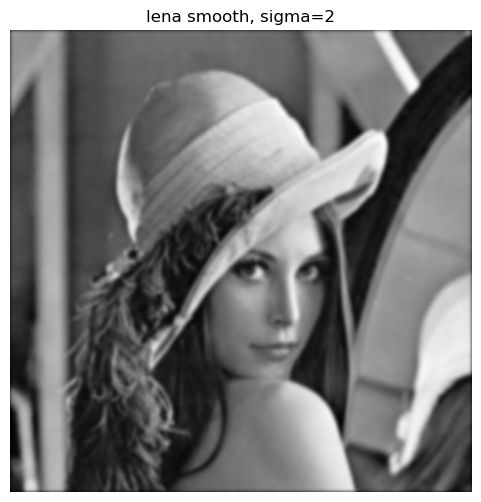

In [64]:
# Define the value of σ
sigma = 2.0

# Create the Gaussian kernel
gaussian_kernel = gaussianKernel(sigma)

# Convolve the image with the Gaussian kernel to apply smoothing
smoothed_lena = convolve2d(lena, gaussian_kernel, mode='same')

imshow(smoothed_lena, title='lena smooth, sigma=2')

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

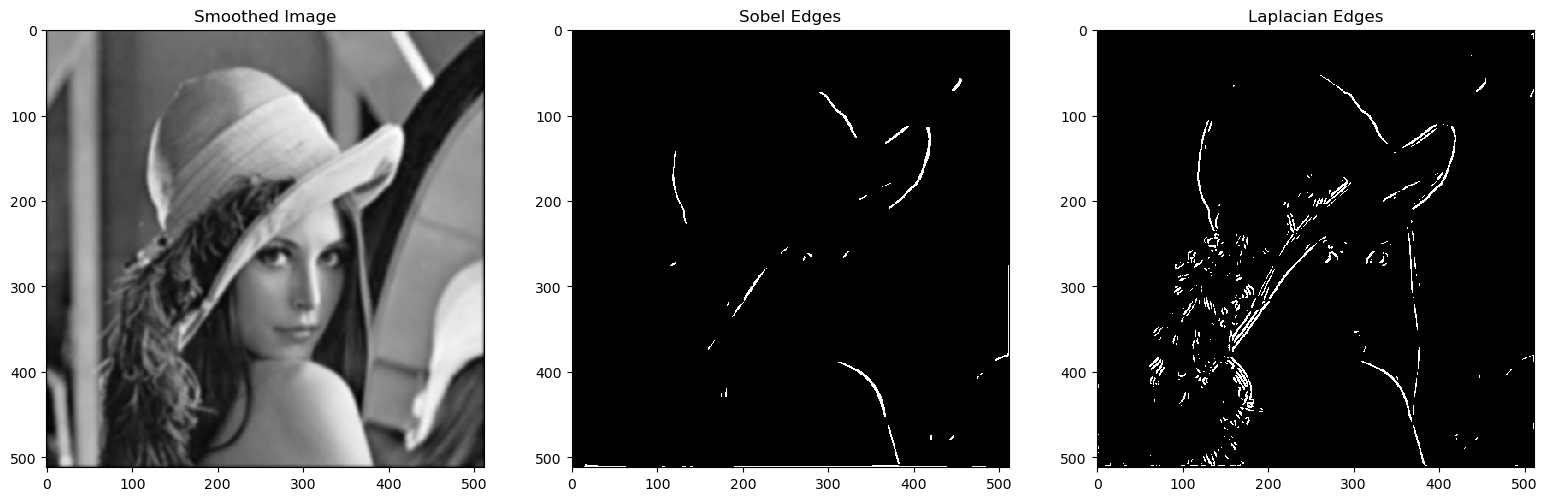

In [67]:
# Apply Sobel detector to the smoothed image
sobel_threshold = 200
sobel_result, _, _ = SobelDetector(smoothed_lena, sobel_threshold)

# Apply Laplacian detector to the smoothed image
laplacian_threshold = 10
laplacian_result = LaplacianDetector(smoothed_lena, laplacian_threshold)


# Display the results
niceDisplay14([smoothed_lena, sobel_result, laplacian_result], ["Smoothed Image", "Sobel Edges", "Laplacian Edges"])


```With a threshold value of 200 for Sobel, The contours of the image have largely disappeared, it because for a really high threshold value, only strong gradient changes are considered as edges, and weaker gradient changes are ignored. But with a threshold value of 10 for Lapacian, because of the threshold value is very low, so even weaker grandient changes are considered as edges, so it almost keep the contours. ```

```And we could see there are still some noise on Laplacian Edges, and Laplacian Edges has more fine and sharp edges and more .```

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

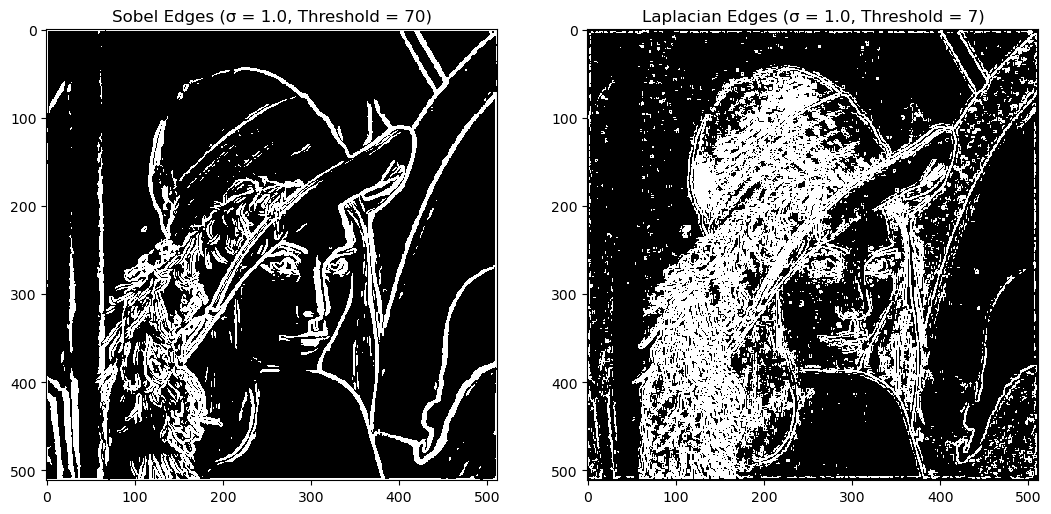

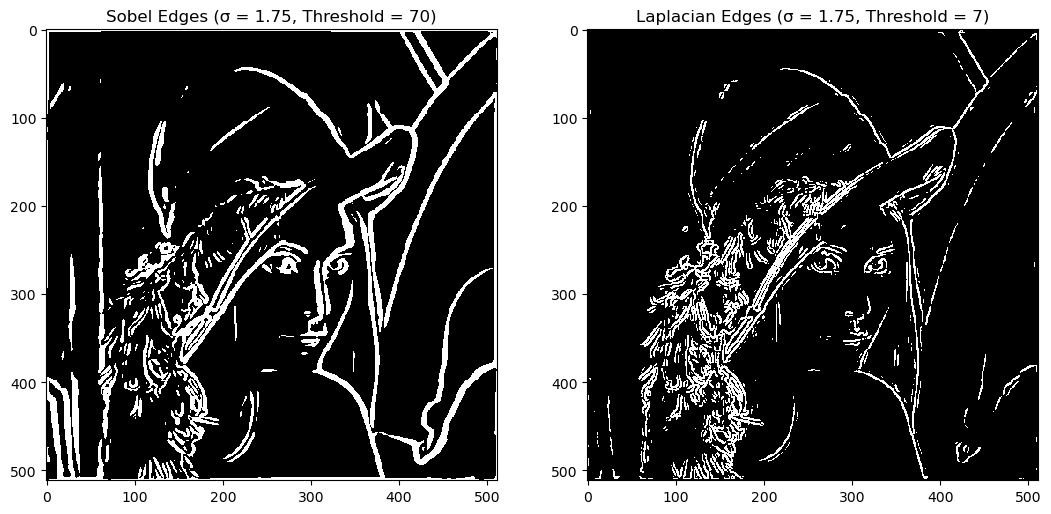

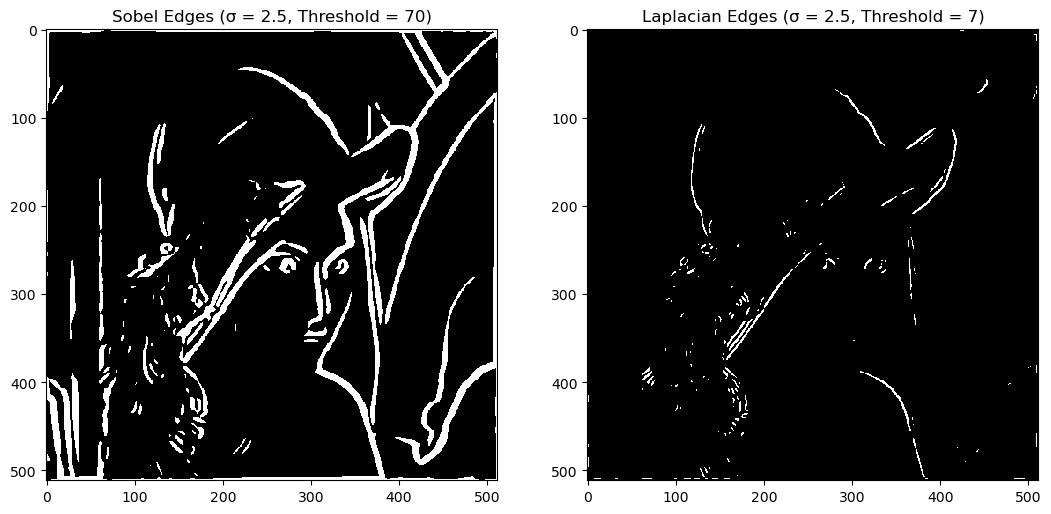

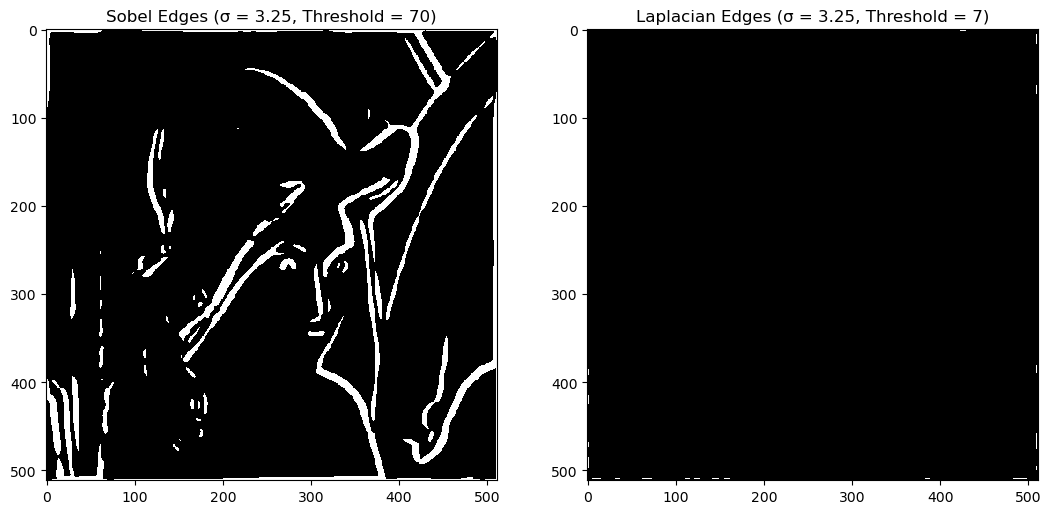

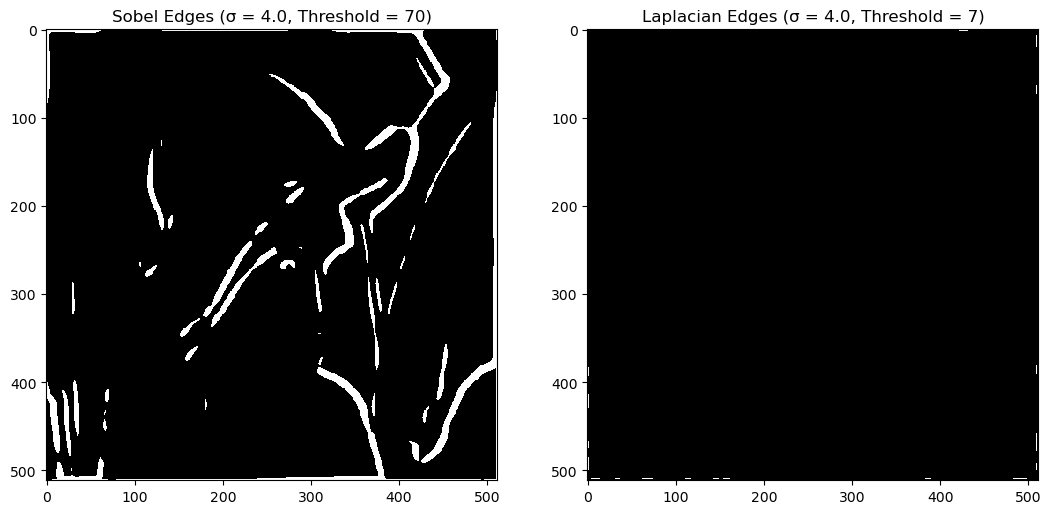

In [76]:
# Define the range of σ values
sigma1 = 1.0
sigma2 = 4.0
num = 5
# Define threshold values
sobel_threshold = 70
laplacian_threshold = 7

# Initialize lists to store results
sobel_results = []
laplacian_results = []

for sigma in np.linspace(sigma1, sigma2, num): 
    # Apply Gaussian smoothing with the current σ
    smoothed_lena = convolve2d(lena, gaussianKernel(sigma), mode='same')
    
    # Apply Sobel detector
    sobel_result, _, _ = SobelDetector(smoothed_lena, sobel_threshold)
    sobel_results.append(sobel_result)
    
    # Apply Laplacian detector
    laplacian_result = LaplacianDetector(smoothed_lena, laplacian_threshold)
    laplacian_results.append(laplacian_result)

# Display the results using niceDisplay14_with_axes
for i, sigma in enumerate(np.linspace(sigma1, sigma2, num)):
    title = f'Sobel Edges (σ = {sigma}, Threshold = {sobel_threshold})'
    title2 = f'Laplacian Edges (σ = {sigma}, Threshold = {laplacian_threshold})'
    niceDisplay14([sobel_results[i], laplacian_results[i]], [title, title2])


 - Laplacian Detector：
     - Higher $\sigma$(3.0): The noise is reduced, but when the value of sigma is greater than 3, the contour is also gone. Because the Laplacian is inherently more sensitive to noise, the change in noise is significant.
     - Lower $\sigma$(like 1.0): More noise, but more precise contour localisation, retaining more high-frequency information
 - Sobel Detector:
     - Higher $\sigma$(like 4.0): The sobel detector is inherently insensitive to noise, and the noise diminishes as the sigma increases, but since there is little noise even at low $\sigma$ values, the change is not noticeable, but the contour edges are fuzzier, less defined, and have wider edges.
     - Lower $\sigma$(like 1.0): noise is ok, more precise contour localisation

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

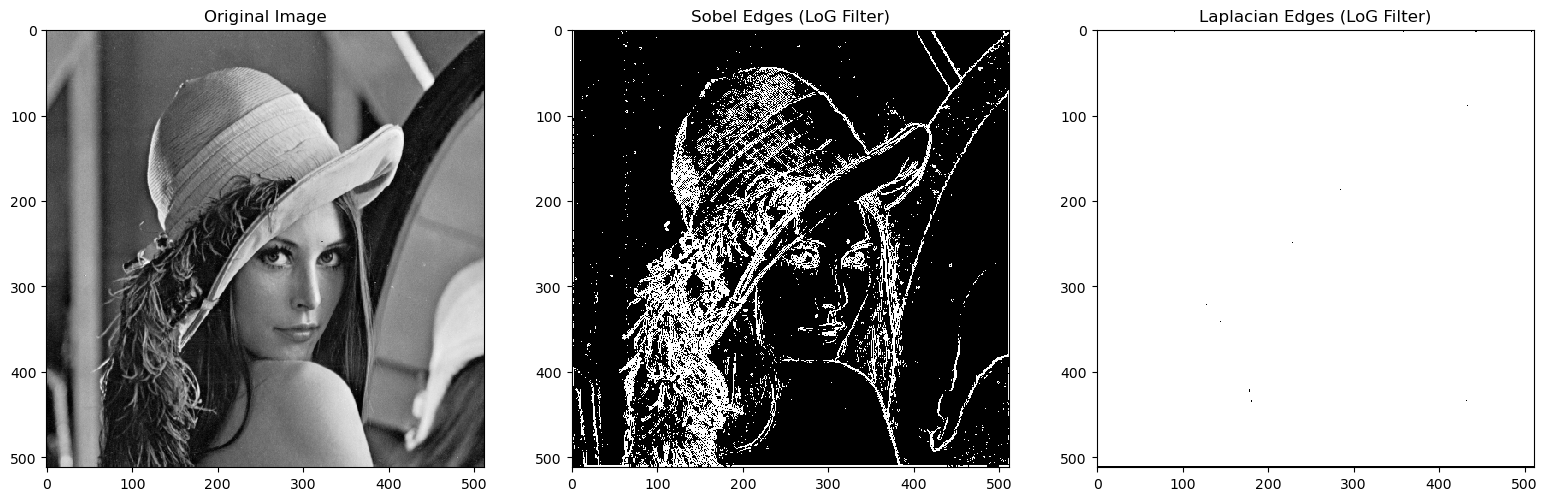

In [98]:
# Define the LoG filter kernel
log_filter = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])

# Convolve the image with the LoG filter
log_result = convolve2d(lena, log_filter, mode='same')

# Apply Sobel detector to the LoG result
sobel_threshold = 200
sobel_result, _, _ = SobelDetector(log_result, sobel_threshold)

# Apply Laplacian detector to the LoG result
laplacian_threshold = 10
laplacian_result = LaplacianDetector(log_result, laplacian_threshold)

# Display the results
niceDisplay14([lena, sobel_result, laplacian_result], ["Original Image", "Sobel Edges (LoG Filter)", "Laplacian Edges (LoG Filter)"])


5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

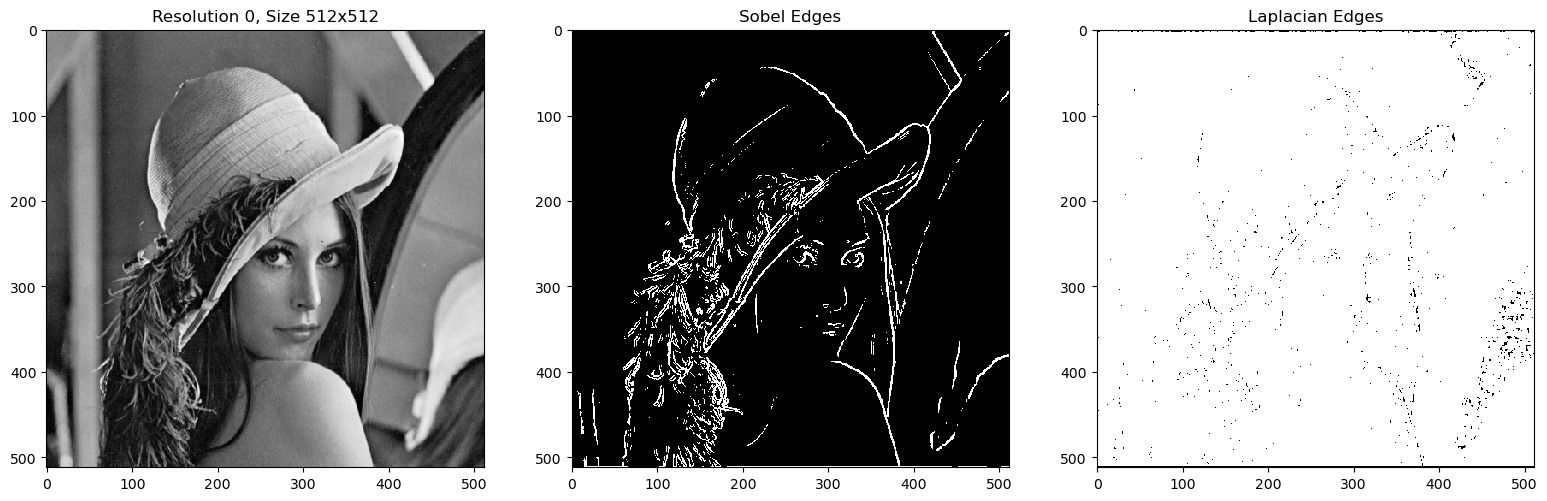

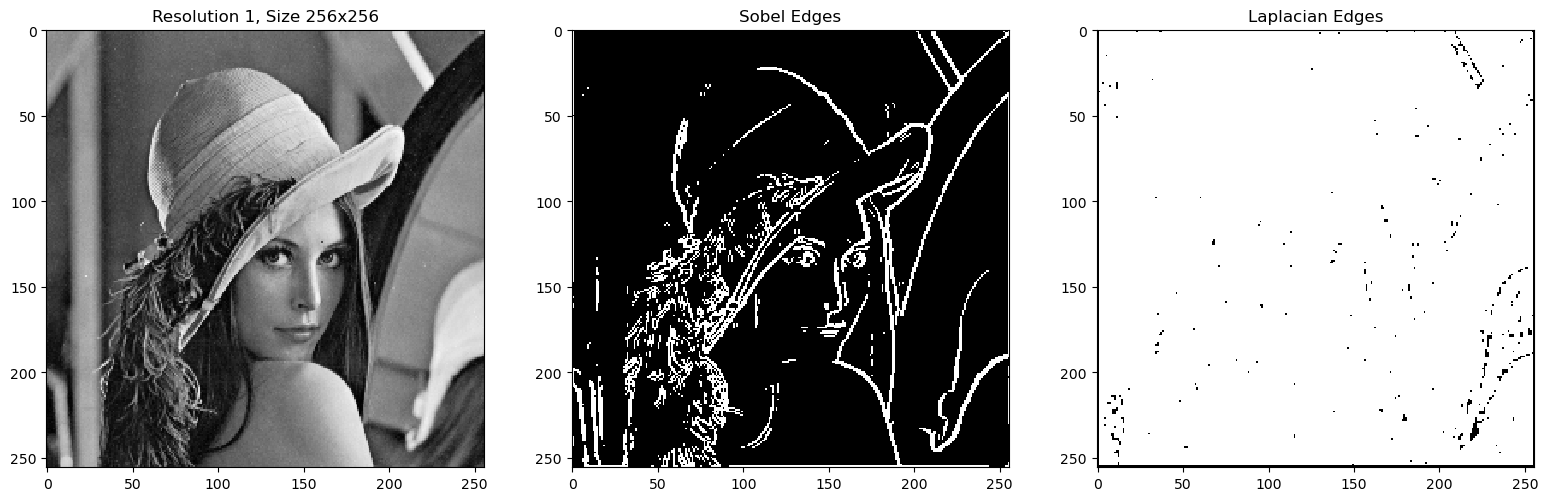

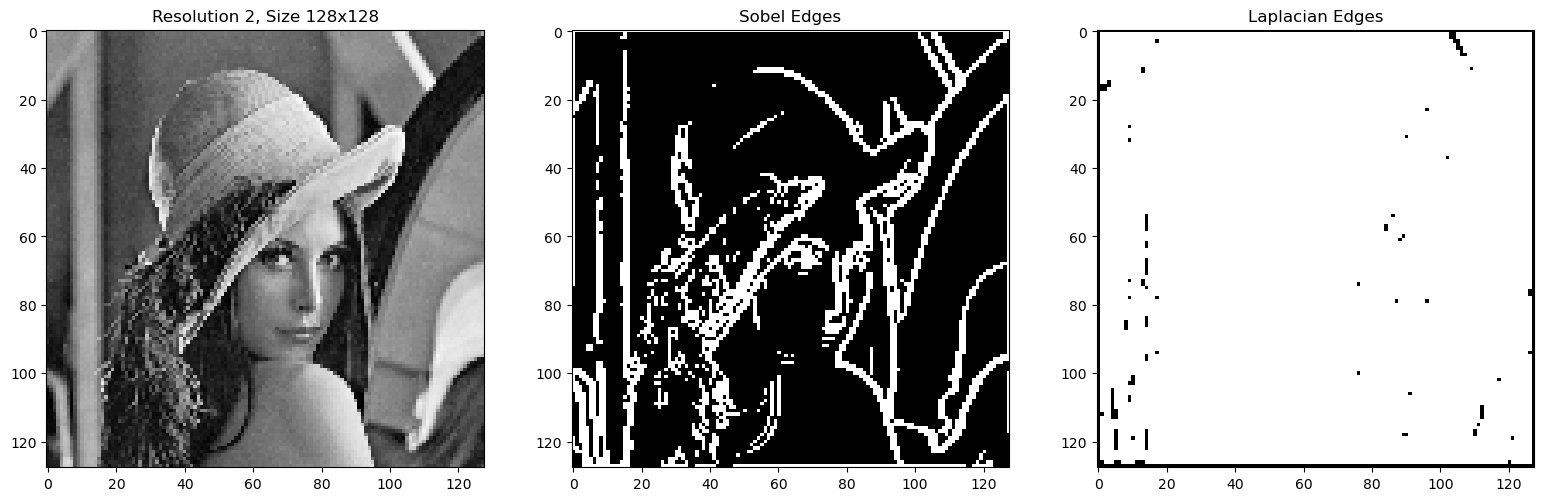

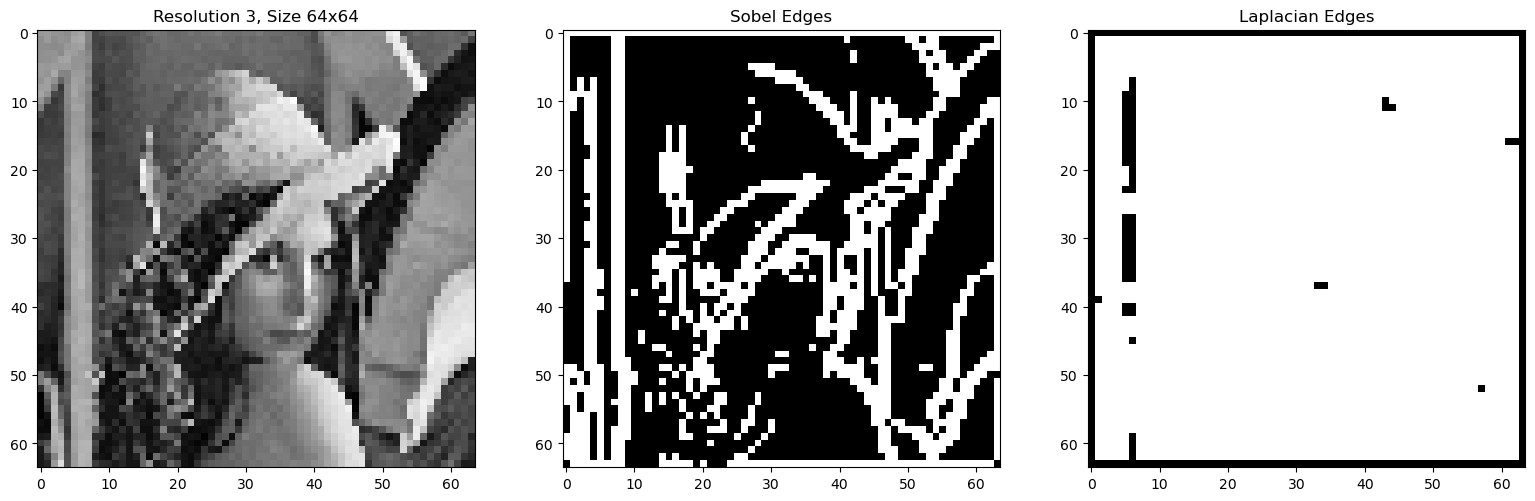

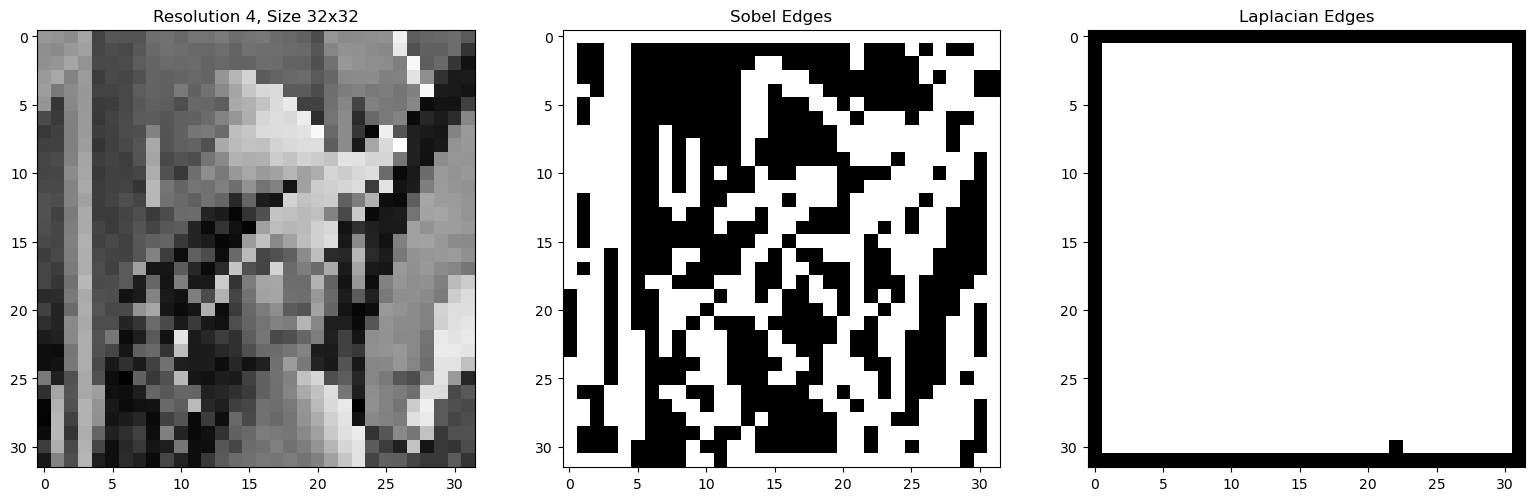

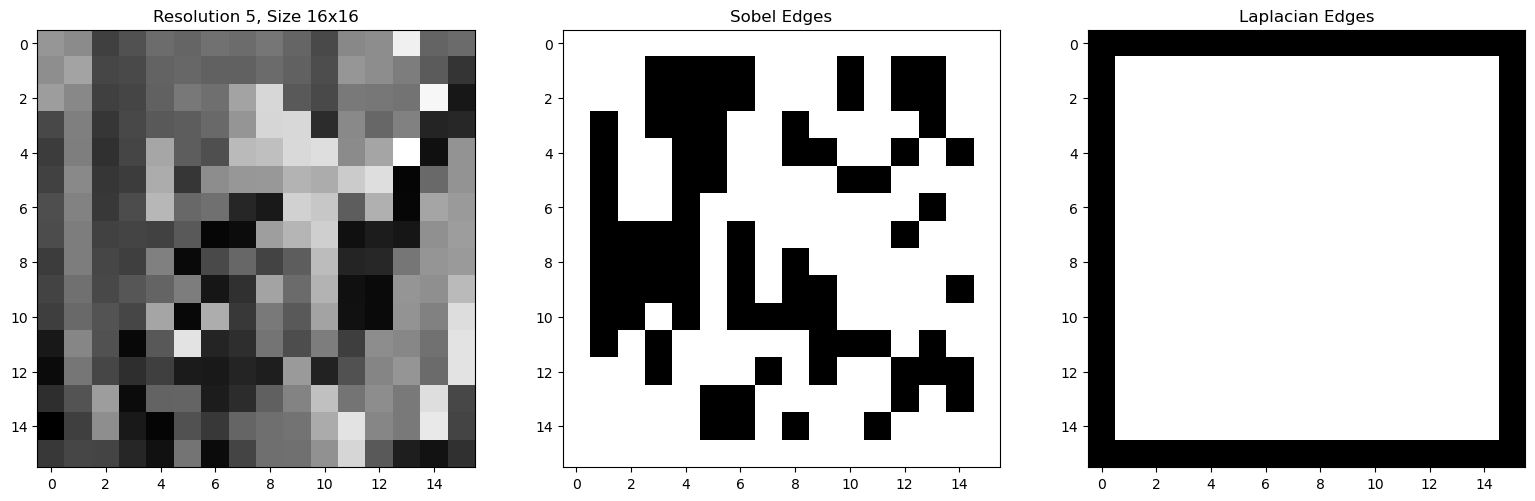

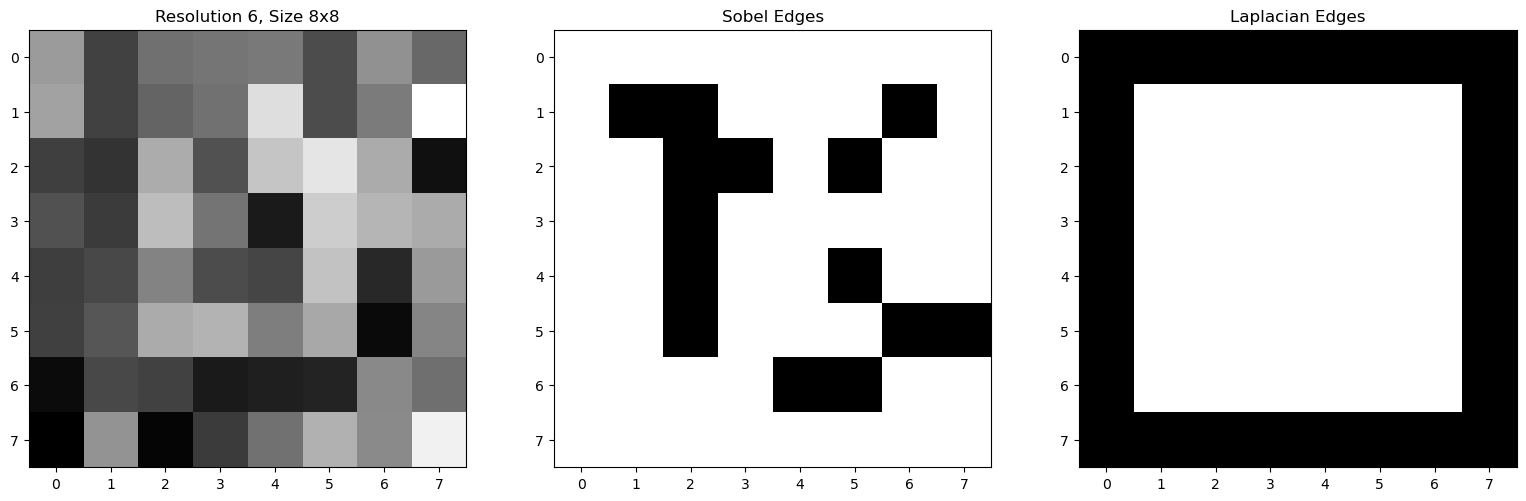

In [103]:
# Define a function for multiresolution decomposition
def multiresolution_decomposition(image, max_size):
    decompositions = [image]
    current_image = image.copy()
    while current_image.shape[0] > max_size and current_image.shape[1] > max_size:
        current_image = current_image[::2, ::2]  # Downsample by a factor of 2
        decompositions.append(current_image)
    return decompositions

# Apply multiresolution decomposition
max_size = 8
decompositions = multiresolution_decomposition(lena, max_size)

# Initialize lists to store the results for each resolution
sobel_results = []
laplacian_results = []

# Apply Sobel and Laplacian detectors for each resolution
for i, image in enumerate(decompositions):
    sobel_threshold = 200
    laplacian_threshold = 10
    
    # Apply Sobel detector
    sobel_result, _, _ = SobelDetector(image, sobel_threshold)
    sobel_results.append(sobel_result)
    
    # Apply Laplacian detector
    laplacian_result = LaplacianDetector(image, laplacian_threshold)
    laplacian_results.append(laplacian_result)
    
    # Display the results for each resolution
    title = f"Resolution {i}, Size {image.shape[0]}x{image.shape[1]}"
    niceDisplay14([image, sobel_result, laplacian_result], [title, "Sobel Edges", "Laplacian Edges"])
